In [1]:
#!pip install matplotlib tqdm tensorflow_datasets ipywidgets

In [2]:
import tensorflow as tf
import json
import os
from glob import glob
from datasets import preprocess, restore_image, car_labels
from schedulers import WarmupScheduler
from statistics import mean

import smdebug.tensorflow as smd
from smdebug.core.collection import CollectionKeys
from smdebug.tensorflow import SaveConfig

# Notebook imports
import matplotlib.pyplot as plt
from tqdm import tqdm

tf.config.optimizer.set_experimental_options({"auto_mixed_precision": True})
#tf.config.optimizer.set_jit(True)

[2021-01-26 19:22:37.485 tensorflow-2-3-gpu--ml-g4dn-xlarge-33edf42bcb5531c041d8b56553ba:168 INFO utils.py:27] RULE_JOB_STOP_SIGNAL_FILENAME: None
[2021-01-26 19:22:37.729 tensorflow-2-3-gpu--ml-g4dn-xlarge-33edf42bcb5531c041d8b56553ba:168 INFO profiler_config_parser.py:102] Unable to find config at /opt/ml/input/config/profilerconfig.json. Profiler is disabled.


In [3]:
train_file_pattern = '/root/data/cars196/2.0.0/cars196-train.tfrecord-*'
val_file_pattern = '/root/data/cars196/2.0.0/cars196-test.tfrecord-*'
batch_size = 32

In [4]:
train_tdf = tf.data.TFRecordDataset(glob(train_file_pattern))
train_tdf = train_tdf.map(preprocess)
train_tdf = train_tdf.shuffle(batch_size*8).batch(batch_size).repeat().prefetch(tf.data.experimental.AUTOTUNE)
train_tdf = iter(train_tdf)

val_tdf = tf.data.TFRecordDataset(glob(val_file_pattern))
val_tdf = val_tdf.map(preprocess)
val_tdf = val_tdf.batch(batch_size).repeat().prefetch(tf.data.experimental.AUTOTUNE)
val_tdf = iter(val_tdf)

Cadillac SRX SUV 2012


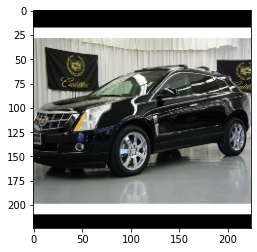

In [23]:
images, labels = next(train_tdf)
plt.imshow(restore_image(images[0]))
print(car_labels[labels[0].numpy()])

In [11]:
model = tf.keras.applications.ResNet50(include_top=True, weights=None, classes=196)
loss_func = tf.keras.losses.SparseCategoricalCrossentropy(name='loss')
lr_schedule = tf.keras.optimizers.schedules.PiecewiseConstantDecay([50000, 75000], [1e-2, 1e-3, 1e-4])
lr_schedule = WarmupScheduler(lr_schedule, 1e-3, 1000)
optimizer = tf.keras.optimizers.SGD(learning_rate=lr_schedule, momentum=0.9)
optimizer = tf.keras.mixed_precision.experimental.LossScaleOptimizer(optimizer, 128)

In [12]:
import shutil
out_dir = "/root/sagemaker_classification/debugger"
shutil.rmtree(out_dir, ignore_errors=True)
# First Party
import smdebug.tensorflow as smd
from smdebug.core.collection import CollectionKeys
from smdebug.tensorflow import SaveConfig


In [13]:
include_collections = [
    CollectionKeys.LOSSES,
]
save_config = SaveConfig(save_interval=100)
hook = smd.KerasHook(
        out_dir=out_dir,
        save_config=SaveConfig(save_interval=10),
        include_collections=include_collections,
        include_regex="loss*"
    )

hook.wrap_optimizer(optimizer)
hook.register_model(model)

[2021-01-26 19:29:06.089 tensorflow-2-3-gpu--ml-g4dn-xlarge-33edf42bcb5531c041d8b56553ba:168 INFO hook.py:199] tensorboard_dir has not been set for the hook. SMDebug will not be exporting tensorboard summaries.
[2021-01-26 19:29:06.098 tensorflow-2-3-gpu--ml-g4dn-xlarge-33edf42bcb5531c041d8b56553ba:168 INFO hook.py:253] Saving to /root/sagemaker_classification/debugger
[2021-01-26 19:29:06.098 tensorflow-2-3-gpu--ml-g4dn-xlarge-33edf42bcb5531c041d8b56553ba:168 INFO state_store.py:67] The checkpoint config file /opt/ml/input/config/checkpointconfig.json does not exist.


In [14]:
#@tf.function
def train_step(images, labels, model, optimizer, loss_func):
    with hook.wrap_tape(tf.GradientTape()) as tape:
        logits = model(images, training=True)
        loss = loss_func(labels, logits)
        scaled_loss = optimizer.get_scaled_loss(loss)
    scaled_gradients = tape.gradient(scaled_loss, model.trainable_variables)
    gradients = optimizer.get_unscaled_gradients(scaled_gradients)
    #gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    return loss

#@tf.function
def predict(images, model):
    logits = model(images, training=False)
    probs = tf.math.softmax(logits)
    pred = tf.math.top_k(probs)
    return pred

#@tf.function
def eval_step(images, labels, model):
    probs, preds = predict(images, model)
    accuracy = tf.reduce_mean(tf.cast(tf.squeeze(preds) == labels, tf.float32))
    return accuracy

In [1]:
loss_history = []
accuracy_history = []
epochs = 5
steps_per_epoch = 100
eval_steps = 100
for epoch in range(epochs):
    print("starting epoch {}".format(epoch + 1))
    pbar = tqdm(range(steps_per_epoch))
    for i in pbar:
        images, labels = next(train_tdf)
        loss_history.append(train_step(images, labels, model, optimizer, loss_func).numpy())
        current_learning_rate = lr_schedule(optimizer.iterations)
        pbar.set_description("Loss {0:.4f}, LR: {1:.4f}".format(mean(loss_history[-50:]),
                                                                current_learning_rate.numpy()))
    for i in tqdm(range(eval_steps)):
        images, labels = next(train_tdf)
        accuracy_history.append(eval_step(images, labels, model).numpy())
    print("Eval accuracy: {0:.4f}".format(mean(accuracy_history[-eval_steps:])))

'loss_history = []\naccuracy_history = []\nepochs = 5\nsteps_per_epoch = 100\neval_steps = 100\nfor epoch in range(epochs):\n    print("starting epoch {}".format(epoch + 1))\n    pbar = tqdm(range(steps_per_epoch))\n    for i in pbar:\n        images, labels = next(train_tdf)\n        loss_history.append(train_step(images, labels, model, optimizer, loss_func).numpy())\n        current_learning_rate = lr_schedule(optimizer.iterations)\n        pbar.set_description("Loss {0:.4f}, LR: {1:.4f}".format(mean(loss_history[-50:]),\n                                                                current_learning_rate.numpy()))\n    for i in tqdm(range(eval_steps)):\n        images, labels = next(train_tdf)\n        accuracy_history.append(eval_step(images, labels, model).numpy())\n    print("Eval accuracy: {0:.4f}".format(mean(accuracy_history[-eval_steps:])))'